## **Importing the neccesary Libraries**

In [44]:
import sys

!pip install ydata-profiling                                         #Installs the ydata-profiling package, which is used for generating detailed data profiles.
!jupyter nbextension enable --py widgetsnbextension
!pip install matplotlib                                              #Installs matplotlib for plotting.
!pip install graphviz

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Import Dataset**

In [45]:
from google.colab import files
uploaded = files.upload()

Saving bbc-news-data.csv to bbc-news-data (1).csv


In [46]:
import pandas as pd                   #Imports the pandas library as pd
import numpy as np                    #Imports the numpy library for numerical computing

data_file="bbc-news-data.csv"

data = pd.read_csv(data_file,sep='\t')     ## Load the CSV file into a DataFrame

In [4]:
data.head(10)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
5,business,006.txt,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...
6,business,007.txt,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...
7,business,008.txt,India calls for fair trade rules,"India, which attends the G7 meeting of seven ..."
8,business,009.txt,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...
9,business,010.txt,Court rejects $280bn tobacco case,A US government claim accusing the country's ...


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


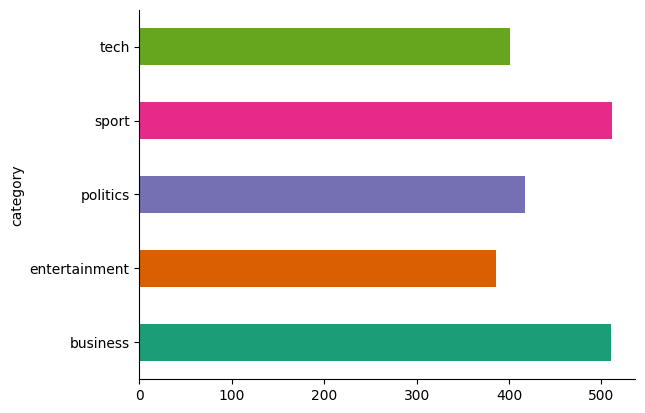

In [6]:


# @title category

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# ****Ydata Profiling****

In [6]:
from ydata_profiling import ProfileReport
# Generate the data profiling report
ydatareport = ProfileReport(data)
#Display report
ydatareport

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# **Text cleaning/Stop Words Removal**

Removing irrelevant characters, punctuation, and extra spaces reduces noise in the data, allowing the model to focus on meaningful information.Converting text to lowercase ensures uniformity, so the model treats "The" and "the" as the same word.Removing stop words (common words like "the", "is", "in") reduces the number of features, focusing the model on more informative words.Clean data can lead to faster and more efficient training because the model has fewer irrelevant features to consider. Reducing feature dimensionality (e.g., through stemming and stop word removal) can lead to better generalization and less overfitting. Lemmatization reduces words to their base or root form. For example, "running" and "ran" both become "run". This normalization helps the model to better understand the context and meaning of words, leading to more accurate predictions.By reducing different forms of a word to a single form, lemmatization reduces the number of unique words (features). This helps the model to generalize better and avoid overfitting.

**Text Cleaning without stemming/stop word removal**

In [7]:
#import re                            #Import module for regular expressions

# Text cleaning function
#def clean_text(text):
#   text = re.sub(r'\s+', ' ', text)  # to remove extra spaces, newlines, and tabs.
#   text = re.sub(r'\W', ' ', text)   # to replace all non-word characters with a space.
#  return text.strip().lower()       # to remove any leading and trailing whitespace from the text and Converts the text to lowercase.

### **Text Cleaning using stemming/stop word removal**

In [48]:
# Text cleaning function
def clean_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    #text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text


# Clean the content
data['cleaned_content'] = data['content'].apply(clean_text)

### **Balancing Dataset**

In an imbalanced dataset, models can become biased towards the majority class. This means that the model will predict the majority class more often simply because there are more examples of it, which can result in poor performance on the minority class.So we balanced the dataset by reducing the number of examples in the majority class to match the minority class.


**Key Research Question: •	How does balancing of dataset affect the performance?**

We have used the random sampling and stratified sampling and found that stratified sampling has improved the performance of three classifiers.

In [49]:
# Balance the dataset
min_samples = data['category'].value_counts().min()
balanced_data = data.groupby('category').apply(lambda x: x.sample(min_samples)).reset_index(drop=True)

# **TFIDF Vectorization**

**Max Features in Content(text) Column** Unigram

In [50]:
# Extract the content column
content = data['content']

# Use CountVectorizer to count unique terms
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(content)

# Get the number of unique terms
num_unique_terms = len(vectorizer.get_feature_names_out())

print(f'Number of unique terms (Unigrams): {num_unique_terms}')

Number of unique terms (Unigrams): 28980


**Key research question:**

**•	Is TF-idf effective for the features extraction from news articles?**

News articles typically have a large vocabulary with many unique words. TF-IDF can handle this by giving more importance to unique and meaningful words and less to common words.News articles usually have sparse data, meaning most words appear only in a few documents. The total number of unique words are 28980 .So we experimented with choosing the optimal number of max features and find that it was giving the best performance at max feature=5000. The more number of feature will use more resources.

In [51]:
# Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(balanced_data['cleaned_content'])
y = balanced_data['category']

# **Splitting data into Train-test subset**

Stratified sampling is used so that each class (or stratum) is represented proportionally in both the training and test sets. This helps with imbalanced datasets because it maintains the same class distribution across splits, which helps in providing a more reliable estimate of model performance.

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
# Splitting the balanced data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Check the distribution of the categories in the test set
print("Category distribution in test set:")
print(y_test.value_counts())

Category distribution in test set:
category
politics         97
business         97
sport            97
tech             96
entertainment    96
Name: count, dtype: int64


X: The feature matrix (TF-IDF transformed text data). y: The labels (news categories). test_size=0.25: 25% of the data is reserved for testing, and 75% for training. random_state=42: A seed value for random number generation to ensure reproducibility. Using the same seed value will always produce the same train-test split.

# **Model Training and Evaluation**

Below are the four fumctions for training and evaluation, confusion matrix, plotting confusion matrix and for cross-validation.

Cross-validation provides a more reliable estimate of a model's performance by averaging the results from multiple train-test splits. This reduces the likelihood of overestimating or underestimating the model's true performance.
By using multiple folds, cross-validation reduces the variance associated with a single train-test split, leading to a more stable and reliable performance estimate. We used the 10 fold cross validation for all three algorithms. Ten-fold cross-validation is recommended as a good compromise between computational cost and accuracy estimation." (Kohavi, 1995)

In [53]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix
import seaborn as sns

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=y_test.unique())
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    return accuracy, report, cm, y_pred

# Calculate and print TP, FP, FN, TN
def calculate_metrics(cm):
    for i in range(len(cm)):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        print(f'Class {i}: TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Cross-validation
def cross_validate_model(model, X, y, cv=10):
    scores = cross_val_score(model, X, y, cv=cv)
    print(f"Cross-Validation Scores: {scores}")
    print(f"Mean Accuracy: {scores.mean()}")
    print(f"Standard Deviation: {scores.std()}")

## **Naive Bayes**

Naive bayes Model training:  Naive Bayes classifiers, particularly the Multinomial Naive Bayes, are well-suited for handling sparse data, such as text data represented as TF-IDF or count vectors.

In [54]:
nb_model = MultinomialNB()
nb_accuracy, nb_report, nb_cm, nb_y_pred = train_and_evaluate_model(
    nb_model, X_train, y_train, X_test, y_test)

**Evaluation_nb**

In [55]:
# Print results
print("Naive Bayes Classifier:")
print("Accuracy:", nb_accuracy)
print("Classification Report:\n", nb_report)

Naive Bayes Classifier:
Accuracy: 0.9710144927536232
Classification Report:
                precision    recall  f1-score   support

         tech       0.95      0.95      0.95        97
     politics       0.99      0.96      0.97        96
     business       0.94      0.99      0.96        97
        sport       1.00      0.99      0.99        97
entertainment       0.98      0.97      0.97        96

     accuracy                           0.97       483
    macro avg       0.97      0.97      0.97       483
 weighted avg       0.97      0.97      0.97       483



In [56]:

print("\nMetrics per Class:")
calculate_metrics(nb_cm)


Metrics per Class:
Class 0: TP: 93, FP: 2, TN: 385, FN: 3
Class 1: TP: 96, FP: 6, TN: 380, FN: 1
Class 2: TP: 92, FP: 5, TN: 381, FN: 5
Class 3: TP: 96, FP: 0, TN: 386, FN: 1
Class 4: TP: 92, FP: 1, TN: 386, FN: 4


The above confusion matrix is for five  news categories. Class 1 is tech and it shows that out of total 483 samples used for testing. It predicted 93 out of 97 tech texts correctly, and gave 381 True negatives.

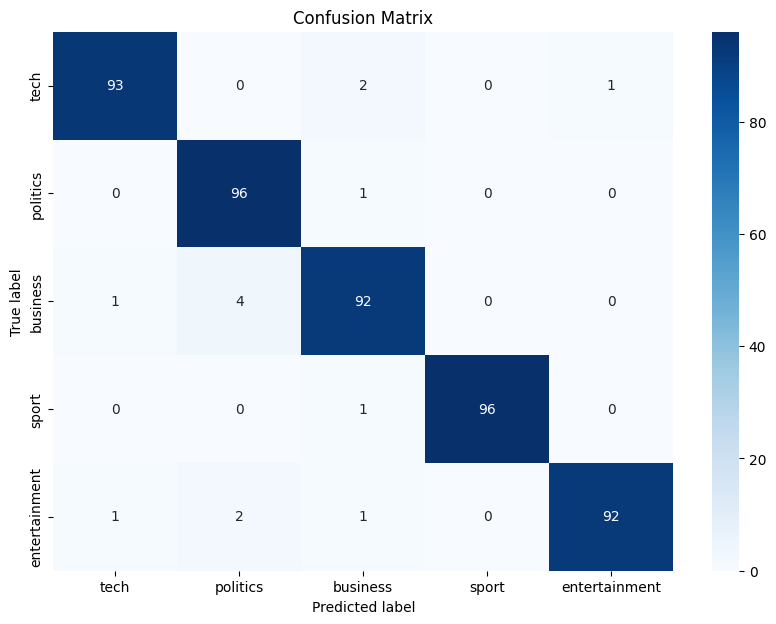

In [57]:
# Plot the confusion matrix
plot_confusion_matrix(nb_cm, classes=y_test.unique())

**Cross Validation_nb**

We used the 10 fold cross validation for all three algorithms. Ten-fold cross-validation is recommended as a good compromise between computational cost and accuracy estimation." (Kohavi, 1995)

In [58]:
print("Naive Bayes Classifier (Cross-Validation):")
cross_validate_model(nb_model, X, y)

Naive Bayes Classifier (Cross-Validation):
Cross-Validation Scores: [0.95336788 0.96373057 0.96373057 0.97409326 0.97927461 0.98963731
 0.97927461 0.98963731 0.97927461 0.97927461]
Mean Accuracy: 0.9751295336787564
Standard Deviation: 0.01106432979485111


## **Decision Tree**

Decision trees do not handle sparse data as efficiently as models like Naive Bayes or linear models. Sparse matrices often contain many zero entries, which may not provide useful information for splits. So we desparse the sparse matrix to a dense format for decision tree implementation and find that perfromance was improved.

In [59]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

Decsion tree model training

In [60]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_accuracy, dt_report, dt_cm, dt_y_pred = train_and_evaluate_model(
    dt_model, X_train, y_train, X_test, y_test)

**Evaluation_dt**

In [61]:
print("Decision Tree Classifier:")
print("Accuracy:", dt_accuracy)
print("Classification Report:\n", dt_report)

Decision Tree Classifier:
Accuracy: 0.8385093167701864
Classification Report:
                precision    recall  f1-score   support

         tech       0.84      0.79      0.81        97
     politics       0.80      0.75      0.77        96
     business       0.81      0.81      0.81        97
        sport       0.90      0.93      0.91        97
entertainment       0.84      0.91      0.87        96

     accuracy                           0.84       483
    macro avg       0.84      0.84      0.84       483
 weighted avg       0.84      0.84      0.84       483



In [62]:
print("\nMetrics per Class:")
calculate_metrics(dt_cm)


Metrics per Class:
Class 0: TP: 87, FP: 17, TN: 370, FN: 9
Class 1: TP: 79, FP: 18, TN: 368, FN: 18
Class 2: TP: 77, FP: 15, TN: 371, FN: 20
Class 3: TP: 90, FP: 10, TN: 376, FN: 7
Class 4: TP: 72, FP: 18, TN: 369, FN: 24


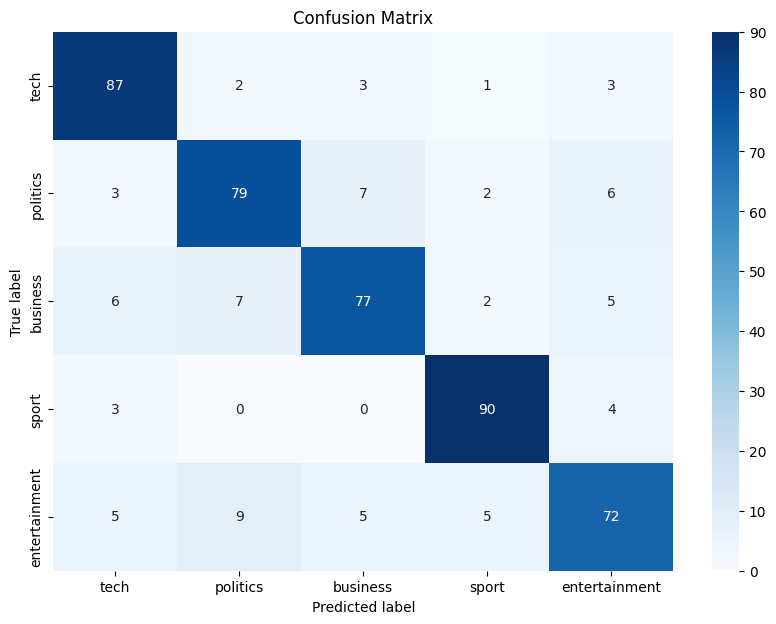

In [63]:
# Plot the confusion matrix
plot_confusion_matrix(dt_cm, classes=y_test.unique())

**Cross Validation_dt**

In [64]:
print("Decision Tree Classifier (Cross-Validation):")
cross_validate_model(dt_model, X, y)

Decision Tree Classifier (Cross-Validation):
Cross-Validation Scores: [0.85492228 0.81865285 0.77720207 0.8134715  0.80829016 0.89119171
 0.83419689 0.83419689 0.86528497 0.8238342 ]
Mean Accuracy: 0.8321243523316062
Standard Deviation: 0.03049521029961069


## **Random Forest**

In [65]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_accuracy, rf_report, rf_cm, rf_y_pred = train_and_evaluate_model(
    rf_model, X_train, y_train, X_test, y_test)

**Evaluation-rf**

In [66]:
print("Random Forest Classifier:")
print("Accuracy:", rf_accuracy)
print("Classification Report:\n", rf_report)

Random Forest Classifier:
Accuracy: 0.9523809523809523
Classification Report:
                precision    recall  f1-score   support

         tech       0.90      0.97      0.94        97
     politics       0.96      0.94      0.95        96
     business       0.96      0.92      0.94        97
        sport       0.97      0.98      0.97        97
entertainment       0.98      0.96      0.97        96

     accuracy                           0.95       483
    macro avg       0.95      0.95      0.95       483
 weighted avg       0.95      0.95      0.95       483



In [67]:
print("\nMetrics per Class:")
calculate_metrics(rf_cm)


Metrics per Class:
Class 0: TP: 92, FP: 2, TN: 385, FN: 4
Class 1: TP: 89, FP: 4, TN: 382, FN: 8
Class 2: TP: 94, FP: 10, TN: 376, FN: 3
Class 3: TP: 95, FP: 3, TN: 383, FN: 2
Class 4: TP: 90, FP: 4, TN: 383, FN: 6


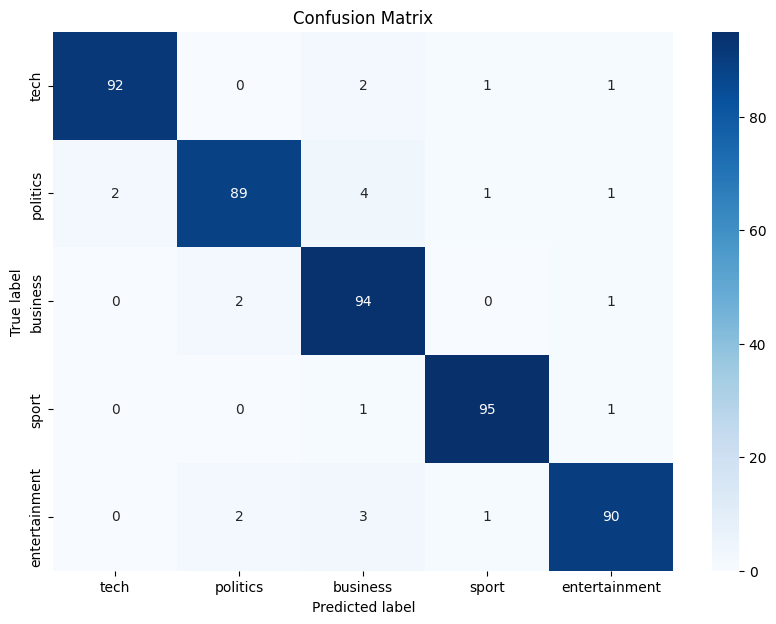

In [68]:
# Plot the confusion matrix
plot_confusion_matrix(rf_cm, classes=y_test.unique())

**Cross Validation_rf**

In [69]:
print("Random Forest Classifier (Cross-Validation):")
cross_validate_model(rf_model, X, y)


Random Forest Classifier (Cross-Validation):
Cross-Validation Scores: [0.94300518 0.95336788 0.93782383 0.95854922 0.97409326 0.96373057
 0.97927461 0.97927461 0.97927461 0.95854922]
Mean Accuracy: 0.9626943005181348
Standard Deviation: 0.014433562981537962


# **Comparison**

We compared the performance of three classifiers and found that Naive bayes and Random forest outperfrormed the decision tree in terms of accuracy,precision and recall.
This answers one of our key research questions:

•	**How efficient are Naïve Bayes, Decision Tree and Random Forest for the news article classification?**

Comparison of Model Accuracies and Reports:
           Model  Accuracy                              Classification Report
0    Naive Bayes  0.971014                 precision    recall  f1-score  ...
1  Decision Tree  0.838509                 precision    recall  f1-score  ...
2  Random Forest  0.952381                 precision    recall  f1-score  ...


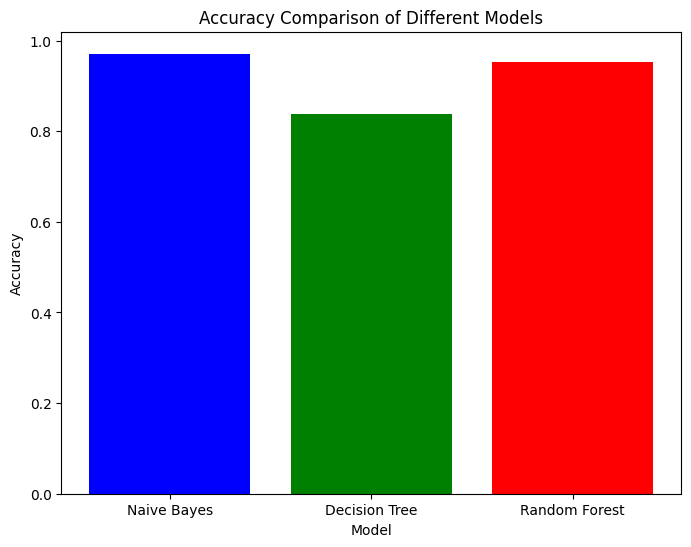

In [70]:
# Store the results in a dictionary
results = {
    "Model": ["Naive Bayes", "Decision Tree", "Random Forest"],
    "Accuracy": [nb_accuracy, dt_accuracy, rf_accuracy],
    "Classification Report": [nb_report, dt_report, rf_report]
}

# Convert the results dictionary to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print("Comparison of Model Accuracies and Reports:")
print(results_df)


# Bar plot for accuracies
plt.figure(figsize=(8, 6))
plt.bar(results_df["Model"], results_df["Accuracy"], color=['blue', 'green', 'red'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Different Models")
plt.show()
